In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from keras import Sequential
from keras.models import load_model
# from models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

Using TensorFlow backend.


In [3]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

### Data Visualization and Preprocessing

In [4]:
rawdf = pd.read_csv('calculary_salary.csv')
#rawdf.head()
salary_df = rawdf[['Bang_cap', 'Mang_cong_viec', 'Nam_kinh_nghiem', 'Vi_tri', 'Nang_luc_work', 'Luong']]
salary_df.head(50)

,Bang_cap,Mang_cong_viec,Nam_kinh_nghiem,Vi_tri,Nang_luc_work,Luong
0,Cao dang,Lap trinh vien,15,Nhan vien,A,19.0
1,Cao dang,Tu van ban hang,2,Nhan vien,D,7.1
2,Dai hoc,PM,0,Nhan vien,C,7.0
3,Cao dang,BA,1,Nhan vien,C,7.0
4,Cao dang,Lap trinh vien,0,Nhan vien,C,7.0
5,Dai hoc,PM,5,Nhan vien,D,8.5
6,Dai hoc,Lap trinh vien,0,Nhan vien,A,12.0
7,Khong bang cap,BA,16,Nhan vien,B,16.0
8,Cao dang,PM,1,Teamlead,A,12.0
9,Cao dang,Ke toan,1,Nhan vien,D,2.2


In [5]:
#rawdf.info()
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
Bang_cap           10000 non-null object
Mang_cong_viec     10000 non-null object
Nam_kinh_nghiem    10000 non-null int64
Vi_tri             10000 non-null object
Nang_luc_work      10000 non-null object
Luong              10000 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 468.8+ KB


In [6]:
#rawdf.describe()
rawdf.describe()

,Unnamed: 0,Tuoi,Nam_kinh_nghiem,He_so_trach_nhiem,Nguong_luong,Thoi_gian_gan_bo,Luong_cu,Luong
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,4999.50000,28.143800,4.539600,1.110850,23.257000,3.725900,14.98045,12.387010
std,2886.89568,8.806706,5.652913,0.375035,4.565527,3.699478,8.64292,6.842766
min,0.00000,18.000000,0.000000,1.000000,15.000000,0.000000,4.00000,2.200000
25%,2499.75000,22.000000,1.000000,1.000000,25.000000,1.000000,9.00000,8.500000
50%,4999.50000,26.000000,3.000000,1.000000,25.000000,3.000000,14.00000,12.000000
75%,7499.25000,32.000000,6.000000,1.000000,25.000000,6.000000,20.00000,15.000000
max,9999.00000,59.000000,39.000000,4.000000,30.000000,14.000000,100.00000,95.000000


In [7]:
(rawdf['Luong'].value_counts()) / rawdf['Luong'].count()

12.00    0.1529
5.00     0.0814
9.00     0.0802
7.00     0.0793
19.00    0.0617
16.00    0.0585
14.00    0.0552
7.10     0.0430
11.10    0.0429
9.10     0.0399
14.10    0.0397
8.50     0.0292
15.50    0.0288
10.50    0.0283
15.00    0.0274
12.50    0.0266
25.00    0.0157
30.20    0.0128
18.00    0.0120
47.00    0.0107
20.00    0.0092
2.20     0.0061
35.00    0.0051
4.20     0.0048
9.20     0.0043
8.40     0.0043
6.20     0.0042
13.40    0.0035
7.46     0.0034
10.46    0.0031
3.46     0.0030
10.40    0.0029
6.40     0.0025
5.46     0.0022
6.30     0.0018
27.50    0.0015
11.30    0.0013
22.00    0.0012
4.30     0.0011
8.30     0.0011
17.00    0.0009
24.50    0.0009
44.00    0.0008
27.20    0.0008
20.12    0.0008
59.00    0.0007
41.00    0.0007
65.00    0.0007
32.00    0.0004
95.00    0.0003
17.12    0.0001
21.50    0.0001
Name: Luong, dtype: float64

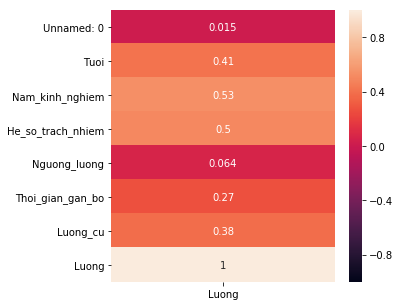

In [27]:
plt.figure(figsize=(5, 5))
#sns.heatmap(rawdf.corr()[['Luong']], annot=True, vmin=-1, vmax=1)
sns.heatmap(rawdf.corr()[['Luong']], annot=True, vmin=-1, vmax=1)

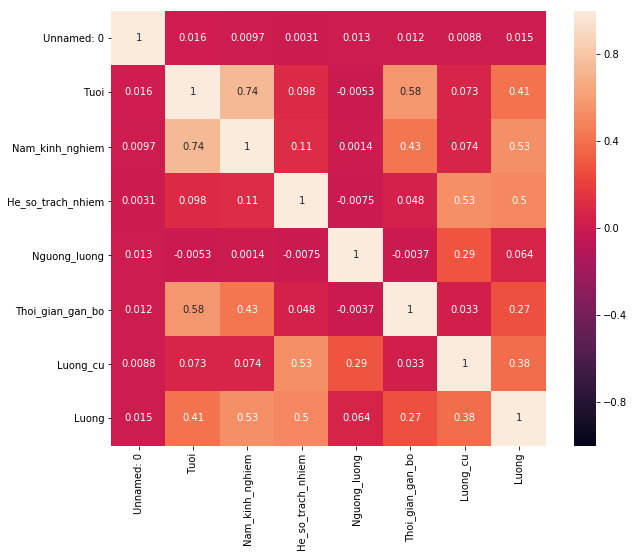

In [28]:
plt.figure(figsize=(10, 8))
#sns.heatmap(rawdf.corr(), annot=True, square=True, vmin=-1, vmax=1)
sns.heatmap(rawdf.corr(), annot=True, square=True, vmin=-1, vmax=1)

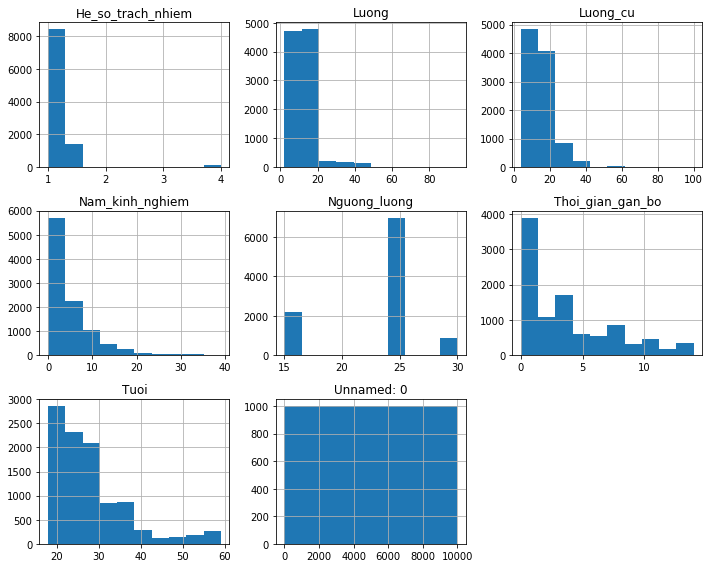

In [24]:
#rawdf.hist(figsize=(10, 8))
rawdf.hist(figsize=(10, 8))
plt.tight_layout()

In [11]:
# Preprocessing data
#df = rawdf.copy()
df = salary_df.copy()

# Batch normalization
ss = StandardScaler()
scale_features = ['Nam_kinh_nghiem']
df[scale_features] = ss.fit_transform(df[scale_features])

# Convert categorical data to one-hot representation
categorical_features = ['Bang_cap', 'Mang_cong_viec', 'Nam_kinh_nghiem', 'Vi_tri', 'Nang_luc_work']
df_cat = pd.get_dummies(df[categorical_features]) # get_dummies giống với one-hot-encoder
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,Luong,Nam_kinh_nghiem,Bang_cap_Cao dang,Bang_cap_Dai hoc,Bang_cap_Khong bang cap,Bang_cap_Thac si,Bang_cap_Tien si,Mang_cong_viec_BA,Mang_cong_viec_Ke toan,Mang_cong_viec_Ky su R&D,...,Mang_cong_viec_Tu van ban hang,Mang_cong_viec_Xu ly data,Vi_tri_Nhan vien,Vi_tri_Teamlead,Vi_tri_Technical leader,Vi_tri_Truong phong,Nang_luc_work_A,Nang_luc_work_B,Nang_luc_work_C,Nang_luc_work_D
0,19.0,1.850537,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,7.1,-0.449278,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
2,7.0,-0.803095,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,7.0,-0.626186,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,7.0,-0.803095,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [12]:
# Convert data from dataframe to numpy array
x_data = df.drop('Luong', axis=1).values
y_data = df['Luong'].values
print(x_data[0])
print(y_data[0])
# Split data train and test
x_train= []
x_test=[]
y_train=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state=0)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

[1.85053666 1.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.         0.         0.         0.
 1.         0.         0.         0.        ]
19.0
x_train.shape =  (9000, 22)
y_train.shape =  (9000,)
x_test.shape =  (1000, 22)
y_test.shape =  (1000,)


## Linear Regression Model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 7200 samples, validate on 1800 samples
Epoch 1/30
7200/7200 [==============================] - 0s 52us/step - loss: 192.7107 - val_loss: 180.8395
Epoch 2/30
7200/7200 [==============================] - 0s 41us/step - loss: 168.2172 - val_loss: 157.6430
Epoch 3/30
7200/7200 [==============================] - 0s 30us/step - loss: 146.8354 - val_loss: 137.4287
Epoch 4/30
7200/7200 [==============================] - 0s 29us/step - loss: 128.1926 - val_loss: 119.8039
Epoch 5/30
7200/7200 [==============================] - 0s 31us/step - loss: 112.0059 - val_loss: 104.5457
Epoch 6/30
7200/7200 [==============================] - 0s 31us/step - loss: 98.0724 - val_loss: 91.3916
Epoch 7/30
7200/7200 [==============================] - 0s 35us/step - loss: 86.1504 - val_loss: 80.2073
Epoch 8/30
7200/7200 [==============================] - 0s 28us/step - loss: 75.9997 - val_loss: 70.6486
Epoch 9/30
7200/7200

<Figure size 576x432 with 0 Axes>

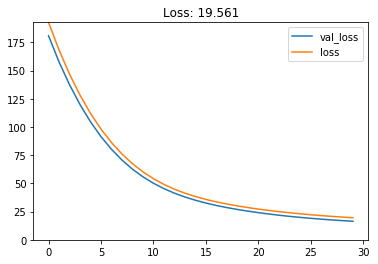

In [13]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(x_train.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(x_train, y_train, verbose=1, epochs=30, validation_split=0.2)
plot_loss(linr_history)

In [14]:
# Evaluate
accuracy = np.mean(abs(1-2) <=1)
print("accuracy =", accuracy )

accuracy = 1.0


## Logistic Regression Model

In [15]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(x_train.shape[1],), activation='sigmoid'))

#lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
lr_model.compile(Adam(lr=0.01), 'mean_squared_error')
lr_history = lr_model.fit(x_train, y_train, verbose=1, epochs=30)
#plot_loss_accuracy(lr_history)

Epoch 1/30
9000/9000 [==============================] - 0s 34us/step - loss: 179.9177
Epoch 2/30
9000/9000 [==============================] - 0s 27us/step - loss: 177.9252
Epoch 3/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.8489
Epoch 4/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.8244
Epoch 5/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.8130
Epoch 6/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.8067
Epoch 7/30
9000/9000 [==============================] - 0s 29us/step - loss: 177.8027
Epoch 8/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.8001
Epoch 9/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.7983
Epoch 10/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.7969
Epoch 11/30
9000/9000 [==============================] - 0s 26us/step - loss: 177.7959
Epoch 12/30
9000/9000 [=============================

## ANN Model

Train on 7200 samples, validate on 1800 samples
Epoch 1/30
7200/7200 [==============================] - 0s 65us/step - loss: 70.5938 - val_loss: 14.8989
Epoch 2/30
7200/7200 [==============================] - 0s 60us/step - loss: 12.8284 - val_loss: 5.3205
Epoch 3/30
7200/7200 [==============================] - 0s 47us/step - loss: 3.9364 - val_loss: 1.3855
Epoch 4/30
7200/7200 [==============================] - 0s 42us/step - loss: 1.6756 - val_loss: 1.0057
Epoch 5/30
7200/7200 [==============================] - 0s 41us/step - loss: 1.3585 - val_loss: 0.8394
Epoch 6/30
7200/7200 [==============================] - 0s 44us/step - loss: 1.1693 - val_loss: 0.8182
Epoch 7/30
7200/7200 [==============================] - 0s 43us/step - loss: 1.0506 - val_loss: 0.6799
Epoch 8/30
7200/7200 [==============================] - 0s 40us/step - loss: 0.9494 - val_loss: 0.6520
Epoch 9/30
7200/7200 [==============================] - 0s 40us/step - loss: 0.8635 - val_loss: 0.6249
Epoch 10/30
7200/7200 

<Figure size 576x432 with 0 Axes>

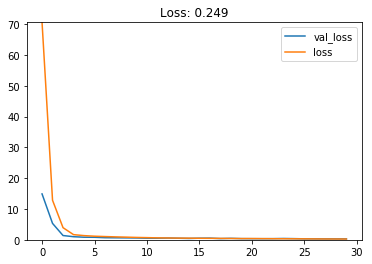

In [16]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(x_train.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

deep_history = deep_model.fit(x_train, y_train, epochs=30, validation_split=0.2)
plot_loss(deep_history)

In [17]:
# Save model
deep_model.save('predict_salary.h5')

In [18]:
# Load model
deep_model = load_model('predict_salary.h5')

In [19]:
# Predict
#y_predict = linr_model.predict(x_test)
y_predict = []
y_predict = deep_model.predict(x_test)
print(type(y_predict))

<class 'numpy.ndarray'>


In [20]:
# Reshape y_test về cùng hình dạng với y_predict
y_test = np.array([y_test]).T

In [21]:
print(y_predict.shape)
print(y_test.shape)

(1000, 1)
(1000, 1)


In [22]:
for i in range(10):
    print("predict = ", y_predict[i])
    print("label = ", y_test[i])
    print('\n')


predict =  [10.490693]
label =  [11.1]


predict =  [46.993397]
label =  [47.]


predict =  [8.446825]
label =  [9.1]


predict =  [16.19112]
label =  [15.5]


predict =  [18.863745]
label =  [19.]


predict =  [14.680143]
label =  [15.]


predict =  [8.618092]
label =  [9.1]


predict =  [11.959455]
label =  [12.]


predict =  [29.04948]
label =  [30.2]


predict =  [12.625004]
label =  [12.]




In [23]:
# Đánh giá độ chính xác với ngưỡng chênh < 1tr
accuracy = (abs(y_test - y_predict) <= 1.0).mean() * 100
print("Độ chính xác dự đoán lương = ", accuracy,"%")

Độ chính xác dự đoán lương =  96.3 %
